In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from transformers import BertTokenizer, BertModel, BertConfig
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from itertools import islice

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Define the paths to save/load the model
model_path = "/kaggle/input/emoregressor/pytorch/default/1/model_21_08_2024.pt"

# Load the EmoBank dataset into a DataFrame
url = 'https://raw.githubusercontent.com/JULIELab/EmoBank/master/corpus/emobank.csv'
df = pd.read_csv(url)

# Preprocess the data
X_train = df[df['split'] == 'train']['text']
y_train = df[df['split'] == 'train'][['V', 'A', 'D']]

X_test = df[df['split'] == 'test']['text']
y_test = df[df['split'] == 'test'][['V', 'A', 'D']]

# Tokenize and encode the text data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class EmoBankDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_length):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        target = self.targets.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'targets': torch.tensor(target, dtype=torch.float)
        }

# Load the pre-trained BERT model
config = BertConfig.from_pretrained('bert-base-uncased')
backbone = BertModel.from_pretrained('bert-base-uncased', config=config)

class EmoRegressor(nn.Module):
    def __init__(self, backbone, num_outputs):
        super(EmoRegressor, self).__init__()
        self.backbone = backbone
        self.fc1 = nn.Linear(config.hidden_size, 512)
        self.fc2 = nn.Linear(512, num_outputs)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids, attention_mask=attention_mask)
        pooled_output = outputs['pooler_output']
        x = F.relu(self.fc1(pooled_output))
        x = self.dropout(x)
        logits = self.fc2(x)
        return logits

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_outputs = 3  # V, A, D values
model = EmoRegressor(backbone, num_outputs)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
num_epochs = 10

train_dataset = EmoBankDataset(X_train, y_train, tokenizer, max_length=128)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = EmoBankDataset(X_test, y_test, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Check if the model exists
if os.path.exists(model_path):
    print("Model found. Loading the model...")
    model.load_state_dict(torch.load(model_path))
else:
    print("No model found. Training a new model...")
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}")

    # Save the trained model
    torch.save(model.state_dict(), model_path)

# Evaluation on test data
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].cpu().numpy()  # Actual values
        outputs = model(input_ids, attention_mask=attention_mask).cpu().numpy()  # Predicted values
        
        y_true.append(targets)
        y_pred.append(outputs)

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model found. Loading the model...
Mean Squared Error (MSE): 0.0471
Root Mean Squared Error (RMSE): 0.2170
Mean Absolute Error (MAE): 0.1652
R-squared (R²): 0.3021


In [3]:
# Use the trained model for predictions
def predict(model, text):
    model.eval()
    encoded_input = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length= 128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
    
    return outputs.squeeze().tolist()


In [4]:
def extract_dialogues(file_path):
    with open(file_path, 'r') as file:
        screenplay_text = file.read()

    lines = screenplay_text.split('\n')
    character_dialogues = []
    current_character = None
    current_dialogue = ''
    
    for line in lines:
        line = line.strip()
        
        if line.isupper() or line == '':
            if current_character:
                character_dialogues.append((current_character, current_dialogue.strip()))
            
            if line.isupper():
                current_character = line
                current_dialogue = ''
            else:
                current_character = None
                current_dialogue = ''
        elif current_character:
            current_dialogue += ' ' + line
    
    if current_character:
        character_dialogues.append((current_character, current_dialogue.strip()))
    
    df = pd.DataFrame(character_dialogues, columns=['Character', 'Dialogue'])
    return df

In [47]:
pd.set_option('display.max_colwidth', None)
character_name = "ARTHUR"
df = extract_dialogues("/kaggle/input/the-joker-script/joker_new_final.txt")
df = df[(df['Character'] == character_name)].reset_index(drop= True)
df = df.reset_index(drop= True)

In [48]:
df.head()

,Character,Dialogue
0,ARTHUR,"--is it just me, or is it getting crazier out there?"
1,ARTHUR,Everyday.
2,ARTHUR,(dodging the subject) I'm sorry. Did I bring what?
3,ARTHUR,Yes ma'am.
4,ARTHUR,"I've been using it as a journal, but also a joke diary. Funny thoughts or, or observations-- Did I tell you I'm pursuing a career in stand-up comedy?"


In [49]:
df['Valence_Predicted'] = df['Dialogue'].apply(lambda x: predict(model, x)[0])
df['Arousal_Predicted'] = df['Dialogue'].apply(lambda x: predict(model, x)[1])
df['Dominance_Predicted'] = df['Dialogue'].apply(lambda x: predict(model, x)[2])


In [50]:
columns_to_scale = ['Valence_Predicted', 'Arousal_Predicted', 'Dominance_Predicted'];
predictions = df[columns_to_scale]

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_predictions = scaler.fit_transform(predictions)
df[columns_to_scale] = scaled_predictions
df.head(3)

,Character,Dialogue,Valence_Predicted,Arousal_Predicted,Dominance_Predicted
0,ARTHUR,"--is it just me, or is it getting crazier out there?",-0.204021,-0.065311,-0.164564
1,ARTHUR,Everyday.,0.363519,-0.404116,0.359273
2,ARTHUR,(dodging the subject) I'm sorry. Did I bring what?,-0.412371,-0.024539,-0.233036


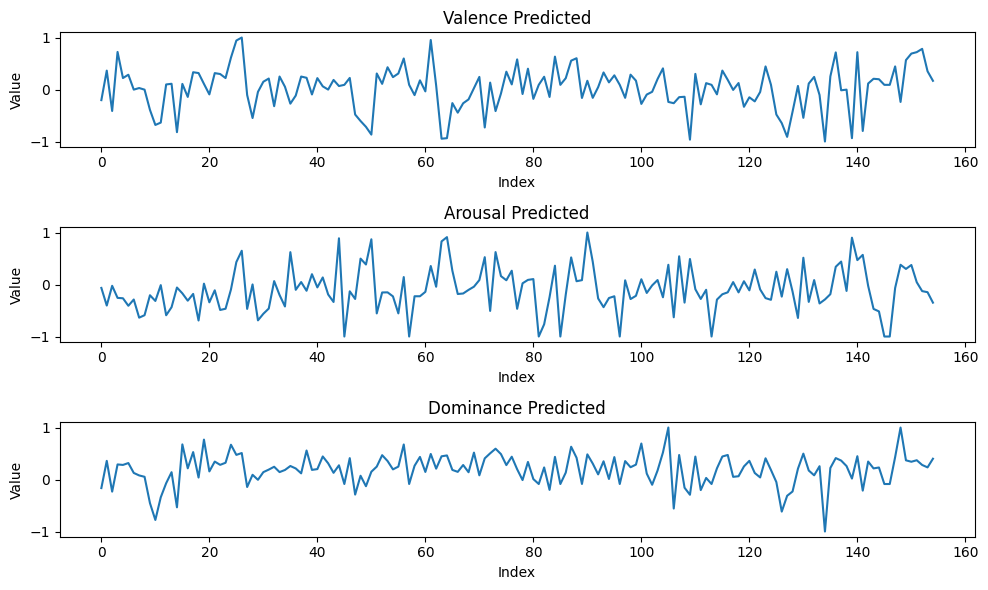

In [51]:
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(df['Valence_Predicted'])
plt.title('Valence Predicted')
plt.xlabel('Index')
plt.ylabel('Value')

plt.subplot(3, 1, 2)
plt.plot(df['Arousal_Predicted'])
plt.title('Arousal Predicted')
plt.xlabel('Index')
plt.ylabel('Value')

plt.subplot(3, 1, 3)
plt.plot(df['Dominance_Predicted'])
plt.title('Dominance Predicted')
plt.xlabel('Index')
plt.ylabel('Value')

plt.tight_layout()
plt.savefig("predictions.png")
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


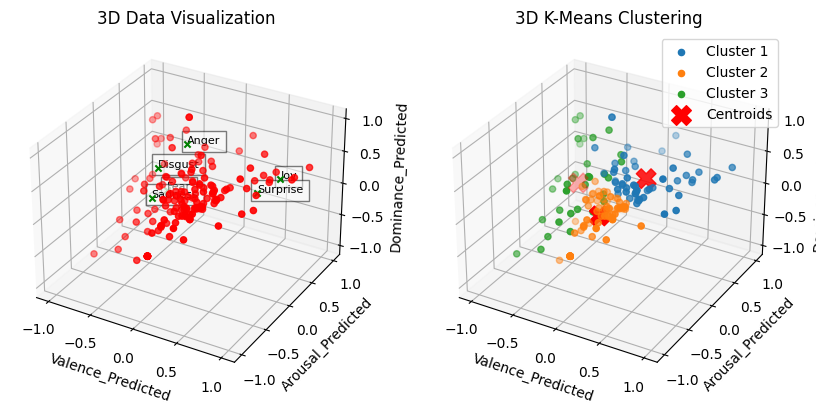

Most Probable Emotions:
Disgust: Nearby Data Points : 24
Sadness: Nearby Data Points : 17
Anger: Nearby Data Points : 16


In [52]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(df['Valence_Predicted'], df['Arousal_Predicted'], df['Dominance_Predicted'], c="red", marker='o')

manual_points = [
    (-0.43, 0.67, 0.34, 'Anger'),
    (0.76, 0.48, 0.35, 'Joy'),
    (0.4, 0.67, -0.13, 'Surprise'),
    (-0.6, 0.35, 0.11, 'Disgust'),
    (-0.64, 0.6, -0.43, 'Fear'),
    (-0.63, 0.27, -0.33, 'Sadness')
]
#Russell, J.A.; Mehrabian, A. Evidence for a three-factor theory of emotions. J. Res. Personal. 1977, 11, 273–294

for point in manual_points:
    ax.scatter(point[0], point[1], point[2], c="green", marker='x')
    ax.text(point[0], point[1], point[2], point[3], color='black', fontsize=8, bbox=dict(facecolor='white', alpha=0.5))



ax.set_xlabel('Valence_Predicted')
ax.set_ylabel('Arousal_Predicted')
ax.set_zlabel('Dominance_Predicted')
plt.title('3D Data Visualization')
# plt.show()






##################################################################################################
#                                              K-MEANS                                           #
##################################################################################################

data = df[['Valence_Predicted', 'Arousal_Predicted', 'Dominance_Predicted']]

# Specify the number of clusters
n_clusters = 3

# Fit KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Visualize the clustering results
# fig = plt.figure(figsize=(8, 6))
ax2 = fig.add_subplot(122, projection='3d')

# Plot data points with color-coded clusters
for i in range(n_clusters):
    cluster_points = data.iloc[labels == i, :]
    ax2.scatter(cluster_points['Valence_Predicted'], cluster_points['Arousal_Predicted'], cluster_points['Dominance_Predicted'], label=f'Cluster {i + 1}', marker='o')

# Plot cluster centers
ax2.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], c='red', marker='X', s=200, label='Centroids')

ax2.set_xlabel('Valence_Predicted')
ax2.set_ylabel('Arousal_Predicted')
ax2.set_zlabel('Dominance_Predicted')
plt.title('3D K-Means Clustering')
plt.legend()
plt.savefig("Visualization_3D.png")
plt.show()


# Calculate the number of nearby data points for each emotion data point
threshold = 0.6 # Adjust the threshold as needed
counts = {}

for point in manual_points:
    manual_point_coords = np.array(point[:3])
    distances = pairwise_distances_argmin_min(np.array(df[['Valence_Predicted', 'Arousal_Predicted', 'Dominance_Predicted']]), [manual_point_coords])[1]
    count_nearby = np.sum(distances < threshold)
    counts[point[-1]] = count_nearby

# Create a dictionary and sort it in descending order
sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}

print("Most Probable Emotions:")
for point_label, count in islice(sorted_counts.items(), 3):
    print(f"{point_label}: Nearby Data Points : {count}")


In [53]:
import pandas as pd
import numpy as np

# Assume df is your DataFrame with the required columns
# Assume manual_points is already defined

# Calculate the Euclidean distance between predicted and manual points
def find_nearest_emotion(row, manual_points):
    min_distance = float('inf')
    nearest_emotion = None
    
    for point in manual_points:
        distance = np.sqrt(
            (row['Valence_Predicted'] - point[0])**2 +
            (row['Arousal_Predicted'] - point[1])**2 +
            (row['Dominance_Predicted'] - point[2])**2
        )
        if distance < min_distance:
            min_distance = distance
            nearest_emotion = point[3]
    
    return nearest_emotion

# Apply the function to each row in the DataFrame
df['emotion'] = df.apply(find_nearest_emotion, manual_points=manual_points, axis=1)

# Display the DataFrame with the new emotion column
print(df)


    Character  \
0      ARTHUR   
1      ARTHUR   
2      ARTHUR   
3      ARTHUR   
4      ARTHUR   
..        ...   
150    ARTHUR   
151    ARTHUR   
152    ARTHUR   
153    ARTHUR   
154    ARTHUR   

                                                                                                                                                  Dialogue  \
0                                                                                                     --is it just me, or is it getting crazier out there?   
1                                                                                                                                                Everyday.   
2                                                                                                       (dodging the subject) I'm sorry. Did I bring what?   
3                                                                                                                                               Yes ma'am.   
4    

/tmp/ipykernel_36/881533367.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


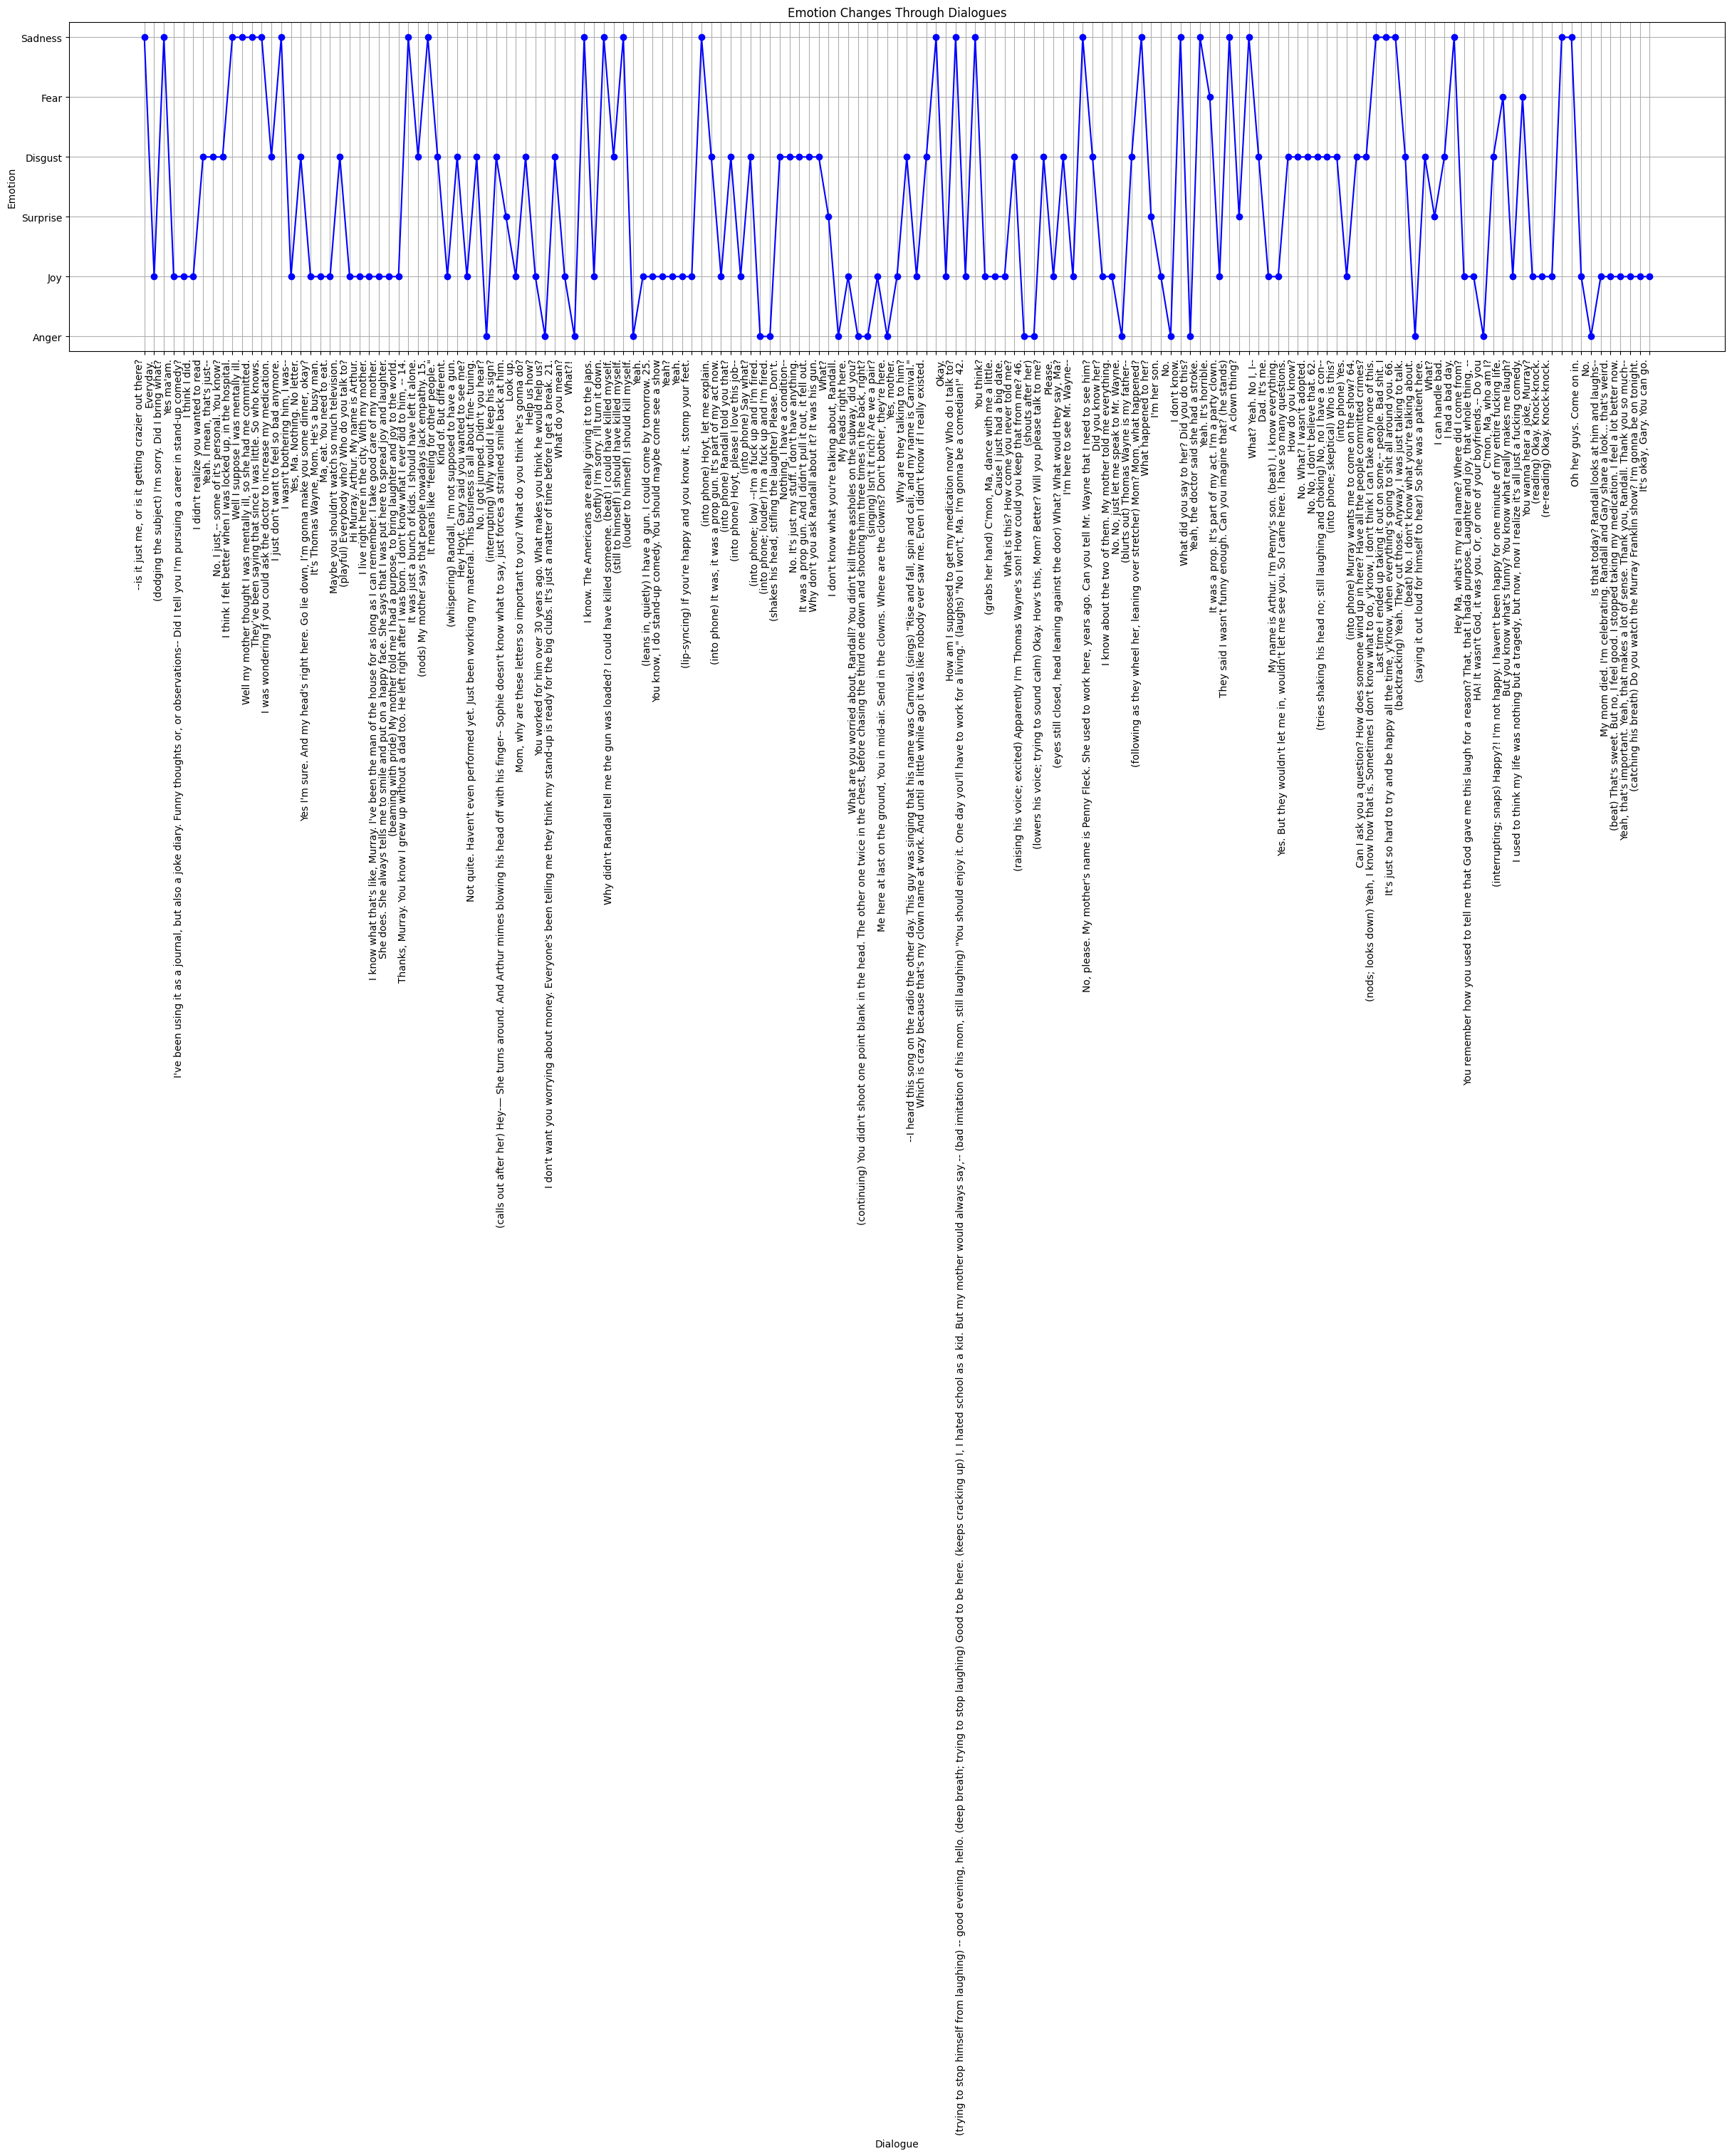

In [63]:
import matplotlib.pyplot as plt

# Map emotions to numeric values for plotting
emotion_mapping = {
    'Anger': 0,
    'Joy': 1,
    'Surprise': 2,
    'Disgust': 3,
    'Fear': 4,
    'Sadness': 5
}

df['emotion_numeric'] = df['emotion'].map(emotion_mapping)

# Plot the emotion changes over time
plt.figure(figsize=(30, 6))
plt.plot(df.index, df['emotion_numeric'], marker='o', linestyle='-', color='b')

# Customize the plot
plt.xticks(df.index, df['Dialogue'], rotation=90, ha='right')  # Display dialogues on x-axis
plt.yticks(list(emotion_mapping.values()), list(emotion_mapping.keys()))  # Label y-axis with emotions
plt.xlabel('Dialogue')
plt.ylabel('Emotion')
plt.title('Emotion Changes Through Dialogues')
plt.grid(True)

# Show the plot
# Adjust layout to make room for the rotated x-axis labels
plt.tight_layout()

# Save the plot to a file
plt.savefig("emotion_changes_plot.png")
plt.show()
